# QAOA Problems

The shallowest depth version of the QAOA consists of the application of two unitary operators: the problem unitary and the driver unitary. The first of these depends on the parameter $\gamma$ and applies a phase to pairs of bits according to the problem-specific cost operator $C$:

$$
    U_C \! \left(\gamma \right) = e^{-i \gamma C } = \prod_{j < k} e^{-i \gamma w_{jk} Z_j Z_k}
$$

whereas the driver unitary depends on the parameter $\beta$, is problem-independent, and serves to drive transitions between bitstrings within the superposition state:

$$
    \newcommand{\gammavector}{\boldsymbol{\gamma}}
    \newcommand{\betavector}{\boldsymbol{\beta}}
    U_B \! \left(\beta \right) = e^{-i \beta B} = \prod_j e^{- i \beta X_j},
    \quad \qquad
    B = \sum_j X_j
$$

where $X_j$ is the Pauli $X$ operator on qubit $j$. These operators can be implemented by sequentially evolving under each term of the product; specifically the problem unitary is applied with a sequence of two-body interactions while the driver unitary is a single qubit rotation on each qubit. For higher-depth versions of the algorithm the two unitaries are sequentially re-applied each with their own $\beta$ or $\gamma$. The number of applications of the pair of unitaries is represented by the hyperparameter $p$ with parameters  $\gammavector = (\gamma_1, \dots, \gamma_p)$ and $\betavector = (\beta_1, \dots, \beta_p)$. For $n$ qubits, we prepare the parameterized state

$$
    \newcommand{\bra}[1]{\langle #1|}
    \newcommand{\ket}[1]{|#1\rangle}
    | \gammavector , \betavector \rangle = U_B(\beta_p)  U_C(\gamma_p ) \cdots U_B(\beta_1) U_C(\gamma_1 ) \ket{+}^{\otimes n},
$$		
where $\ket{+}^{\otimes n}$ is the symmetric superposition of computational basis states. 

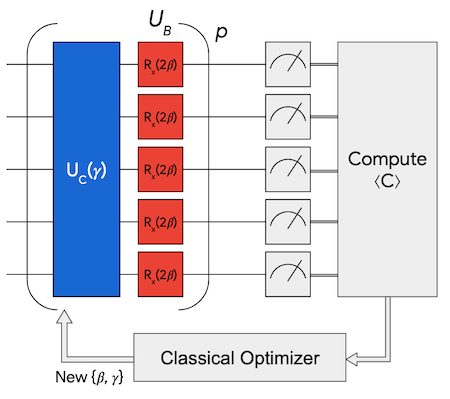

The optimization problems we study in this work are defined through a cost function with a corresponding quantum operator C given by

$$
    C  =  \sum_{j < k}  w_{jk}  Z_j  Z_k
$$

where $Z_j$ dnotes the Pauli $Z$ operator on qubit $j$, and the $w_{jk}$ correspond to scalar weights with values $\{0, \pm1\}$. Because these clauses act on at most two qubits, we are able to associate a graph with a given problem instance with weighted edges given by the $w_{jk}$ adjacency matrix.

In [ ]:
import networkx as nx
import numpy as np
import scipy.optimize
import cirq
import recirq

%matplotlib inline
from matplotlib import pyplot as plt

In [ ]:
# theme colors
QBLUE = '#1967d2'
QRED = '#ea4335ff'
QGOLD = '#fbbc05ff'

## Hardware Grid

First, we study problem graphs which match the connectivity of our hardware, which we term "Hardware Grid problems". Despite results showing that problems on such graphs are efficient to solve on average, we study these problems as they do not require routing. This family of problems is composed of random instances generated by sampling $w_{ij}$ to be $\pm 1$ for edges in the device topology or a subgraph thereof.

In [ ]:
from recirq.qaoa.problems import get_all_hardware_grid_problems
import cirq.contrib.routing as ccr

hg_problems = get_all_hardware_grid_problems(
    device_graph=ccr.gridqubits_to_graph_device(recirq.get_device_obj_by_name('Sycamore23').qubits),
    central_qubit=cirq.GridQubit(6,3),
    n_instances=10,
    rs=np.random.RandomState(5)
)   

instance_i = 0
n_qubits = 23
problem = hg_problems[n_qubits, instance_i]

fig, ax = plt.subplots(figsize=(6,5))
pos = {i: coord for i, coord in enumerate(problem.coordinates)}
nx.draw_networkx(problem.graph, pos=pos, with_labels=False, node_color=QBLUE)
if True:  # toggle edge labels
    edge_labels = {(i1, i2): f"{weight:+d}"
                   for i1, i2, weight in problem.graph.edges.data('weight')}
    nx.draw_networkx_edge_labels(problem.graph, pos=pos, edge_labels=edge_labels)
ax.axis('off')
fig.tight_layout()

## Sherrington-Kirkpatrick model

Next, we study instances of the Sherrington-Kirkpatrick (SK) model, defined on the complete graph with $w_{ij}$ randomly chosen to be $\pm 1$. This is a canonical example of a frustrated spin glass and is most penalized by routing, which can be performed optimally using the linear swap networks at the cost of a linear increase in circuit depth. 

In [ ]:
from recirq.qaoa.problems import get_all_sk_problems

n_qubits = 17
all_sk_problems = get_all_sk_problems(max_n_qubits=17, n_instances=10, rs=np.random.RandomState(5))
sk_problem = all_sk_problems[n_qubits, instance_i]

fig, ax = plt.subplots(figsize=(6,5))
pos = nx.circular_layout(sk_problem.graph)
nx.draw_networkx(sk_problem.graph, pos=pos, with_labels=False, node_color=QRED)
if False:  # toggle edge labels
    edge_labels = {(i1, i2): f"{weight:+d}"
                   for i1, i2, weight in sk_problem.graph.edges.data('weight')}
    nx.draw_networkx_edge_labels(sk_problem.graph, pos=pos, edge_labels=edge_labels)
ax.axis('off')
fig.tight_layout()

## 3-regular MaxCut

Finally, we study instances of the MaxCut problem on 3-regular graphs. This is a prototypical discrete optimization problem with a low, fixed node degree but a high dimension which cannot be trivially mapped to a planar architecture. It more closely matches problems of industrial interest. For these problems, we use an automated routing algorithm to heuristically insert SWAP operations.

In [ ]:
from recirq.qaoa.problems import get_all_3_regular_problems

n_qubits = 22
instance_i = 0
threereg_problems = get_all_3_regular_problems(max_n_qubits=22, n_instances=10, rs=np.random.RandomState(5))
threereg_problem = threereg_problems[n_qubits, instance_i]

fig, ax = plt.subplots(figsize=(6,5))
pos = nx.spring_layout(threereg_problem.graph, seed=11)
nx.draw_networkx(threereg_problem.graph, pos=pos, with_labels=False, node_color=QGOLD)
if False:  # toggle edge labels
    edge_labels = {(i1, i2): f"{weight:+d}"
                   for i1, i2, weight in threereg_problem.graph.edges.data('weight')}
    nx.draw_networkx_edge_labels(threereg_problem.graph, pos=pos, edge_labels=edge_labels)
ax.axis('off')
fig.tight_layout()